```
SOW-MKI95 Computer Graphics & Computer Vision
Generative adversarial networks
```

```
Group number: ...
Student 1 name/number: ...
Student 2 name/number: ...
...
```

In this lab, you will reimplement the DCGAN from the Gluon tutorial, convert it to a WGAN and compare their results after training them on different datasets.

### Task 1 (33 points):

Reimplement the DCGAN from the Gluon tutorial in this notebook. You can find the Gluon tutorial [here](https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html).

In [28]:
!pip install mxnet-cu100

In [29]:
from __future__ import print_function
import os
import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
import numpy as np

In [30]:
epochs = 15 
batch_size = 64
latent_z_size = 100

use_gpu = True
ctx = mx.gpu() if use_gpu else mx.cpu()

lr_GAN = 0.0002
beta1_GAN = 0.5

In [31]:
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
data_path = 'lfw_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    data_file = utils.download(lfw_url)
    with tarfile.open(data_file) as tar:
        tar.extractall(path=data_path)

In [32]:
target_wd = 64
target_ht = 64
img_list = []

def transform(data, target_wd, target_ht):
    # resize to target_wd * target_ht
    data = mx.image.imresize(data, target_wd, target_ht)
    # transpose from (target_wd, target_ht, 3)
    # to (3, target_wd, target_ht)
    data = nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)

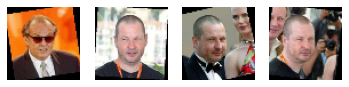

In [33]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i + 10][0])
plt.show()

In [34]:
# build the generator
nc = 3
ngf = 64
ndf = 64

def build_network():
    netG = nn.Sequential()
    with netG.name_scope():
        # input is Z, going into a convolution
        netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
        netG.add(nn.BatchNorm())
        netG.add(nn.Activation('relu'))
        # state size. (ngf*8) x 4 x 4
        netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
        netG.add(nn.BatchNorm())
        netG.add(nn.Activation('relu'))
        # state size. (ngf*8) x 8 x 8
        netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
        netG.add(nn.BatchNorm())
        netG.add(nn.Activation('relu'))
        # state size. (ngf*8) x 16 x 16
        netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
        netG.add(nn.BatchNorm())
        netG.add(nn.Activation('relu'))
        # state size. (ngf*8) x 32 x 32
        netG.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
        netG.add(nn.Activation('tanh'))
        # state size. (nc) x 64 x 64

    # build the discriminator
    netD = nn.Sequential()
    with netD.name_scope():
        # input is (nc) x 64 x 64
        netD.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
        netD.add(nn.LeakyReLU(0.2))
        # state size. (ndf) x 32 x 32
        netD.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
        netD.add(nn.BatchNorm())
        netD.add(nn.LeakyReLU(0.2))
        # state size. (ndf) x 16 x 16
        netD.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
        netD.add(nn.BatchNorm())
        netD.add(nn.LeakyReLU(0.2))
        # state size. (ndf) x 8 x 8
        netD.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
        netD.add(nn.BatchNorm())
        netD.add(nn.LeakyReLU(0.2))
        # state size. (ndf) x 4 x 4
        netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))
    return netG, netD

In [35]:
netG, netD =build_network()
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG_GAN = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr_GAN, 'beta1': beta1_GAN})
trainerD_GAN = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr_GAN, 'beta1': beta1_GAN})

INFO:root:speed: 11.8217336590193 samples/s
INFO:root:discriminator loss = 1.893693, generator loss = 7.507394, binary training acc = 0.523438 at iter 0 epoch 0
INFO:root:speed: 736.779939396601 samples/s
INFO:root:discriminator loss = 0.256301, generator loss = 26.017744, binary training acc = 0.897825 at iter 50 epoch 0
INFO:root:speed: 764.7319831690022 samples/s
INFO:root:discriminator loss = 2.103331, generator loss = 19.430334, binary training acc = 0.854038 at iter 100 epoch 0
INFO:root:speed: 732.4196286544521 samples/s
INFO:root:discriminator loss = 0.883550, generator loss = 3.969842, binary training acc = 0.841267 at iter 150 epoch 0
INFO:root:speed: 741.1597341675341 samples/s
INFO:root:discriminator loss = 0.469289, generator loss = 3.594061, binary training acc = 0.838658 at iter 200 epoch 0


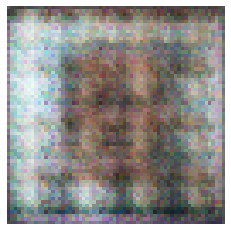

INFO:root:speed: 1368.8842109557465 samples/s
INFO:root:discriminator loss = 0.762399, generator loss = 2.387949, binary training acc = 0.781250 at iter 0 epoch 1
INFO:root:speed: 766.7240472198499 samples/s
INFO:root:discriminator loss = 0.561711, generator loss = 6.566260, binary training acc = 0.861366 at iter 50 epoch 1
INFO:root:speed: 752.6305111547875 samples/s
INFO:root:discriminator loss = 0.228371, generator loss = 5.514105, binary training acc = 0.875851 at iter 100 epoch 1
INFO:root:speed: 773.2549503096644 samples/s
INFO:root:discriminator loss = 0.686382, generator loss = 6.949197, binary training acc = 0.877535 at iter 150 epoch 1
INFO:root:speed: 734.2607649089407 samples/s
INFO:root:discriminator loss = 0.960752, generator loss = 7.400284, binary training acc = 0.875389 at iter 200 epoch 1


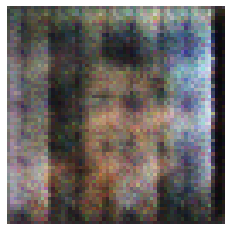

INFO:root:speed: 1308.3307631571251 samples/s
INFO:root:discriminator loss = 0.405381, generator loss = 6.268522, binary training acc = 0.859375 at iter 0 epoch 2
INFO:root:speed: 715.0651465103889 samples/s
INFO:root:discriminator loss = 0.623165, generator loss = 6.365259, binary training acc = 0.885263 at iter 50 epoch 2
INFO:root:speed: 715.1394417640618 samples/s
INFO:root:discriminator loss = 0.391373, generator loss = 4.959344, binary training acc = 0.900603 at iter 100 epoch 2
INFO:root:speed: 725.2993247825606 samples/s
INFO:root:discriminator loss = 0.532164, generator loss = 4.134671, binary training acc = 0.902111 at iter 150 epoch 2
INFO:root:speed: 733.2619180297418 samples/s
INFO:root:discriminator loss = 0.494822, generator loss = 4.071899, binary training acc = 0.894123 at iter 200 epoch 2


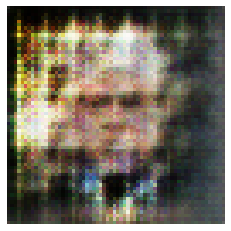

INFO:root:speed: 1462.4729963116117 samples/s
INFO:root:discriminator loss = 0.361869, generator loss = 4.520914, binary training acc = 0.882812 at iter 0 epoch 3
INFO:root:speed: 787.2630853469336 samples/s
INFO:root:discriminator loss = 1.001881, generator loss = 6.515936, binary training acc = 0.890931 at iter 50 epoch 3
INFO:root:speed: 743.8584527903478 samples/s
INFO:root:discriminator loss = 0.184453, generator loss = 5.953589, binary training acc = 0.893564 at iter 100 epoch 3
INFO:root:speed: 710.4079436618227 samples/s
INFO:root:discriminator loss = 0.284150, generator loss = 4.167016, binary training acc = 0.893729 at iter 150 epoch 3
INFO:root:speed: 690.6744404449167 samples/s
INFO:root:discriminator loss = 0.223596, generator loss = 4.996175, binary training acc = 0.886194 at iter 200 epoch 3


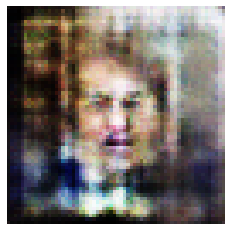

INFO:root:speed: 1371.5349863835397 samples/s
INFO:root:discriminator loss = 0.184628, generator loss = 4.290021, binary training acc = 1.000000 at iter 0 epoch 4
INFO:root:speed: 664.4902517996297 samples/s
INFO:root:discriminator loss = 0.503655, generator loss = 3.466107, binary training acc = 0.923407 at iter 50 epoch 4
INFO:root:speed: 760.1281513259426 samples/s
INFO:root:discriminator loss = 0.457182, generator loss = 6.174402, binary training acc = 0.895498 at iter 100 epoch 4
INFO:root:speed: 700.874034271451 samples/s
INFO:root:discriminator loss = 0.906989, generator loss = 7.887717, binary training acc = 0.900611 at iter 150 epoch 4
INFO:root:speed: 722.5213201767843 samples/s
INFO:root:discriminator loss = 0.515902, generator loss = 5.142111, binary training acc = 0.896105 at iter 200 epoch 4


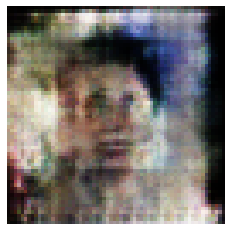

INFO:root:speed: 1350.863331219743 samples/s
INFO:root:discriminator loss = 0.390231, generator loss = 3.173483, binary training acc = 0.929688 at iter 0 epoch 5
INFO:root:speed: 780.4172994848298 samples/s
INFO:root:discriminator loss = 0.299050, generator loss = 4.910303, binary training acc = 0.864277 at iter 50 epoch 5
INFO:root:speed: 714.5778478182167 samples/s
INFO:root:discriminator loss = 0.158733, generator loss = 6.096229, binary training acc = 0.903156 at iter 100 epoch 5
INFO:root:speed: 734.1101621447187 samples/s
INFO:root:discriminator loss = 0.568393, generator loss = 6.284504, binary training acc = 0.881416 at iter 150 epoch 5
INFO:root:speed: 674.0240145835112 samples/s
INFO:root:discriminator loss = 0.357571, generator loss = 3.427211, binary training acc = 0.886699 at iter 200 epoch 5


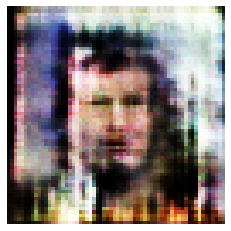

INFO:root:speed: 1354.3802460166096 samples/s
INFO:root:discriminator loss = 0.398408, generator loss = 4.441121, binary training acc = 0.953125 at iter 0 epoch 6
INFO:root:speed: 724.2992871289266 samples/s
INFO:root:discriminator loss = 1.203671, generator loss = 6.432302, binary training acc = 0.909620 at iter 50 epoch 6
INFO:root:speed: 698.2306093624416 samples/s
INFO:root:discriminator loss = 0.248725, generator loss = 4.931818, binary training acc = 0.897973 at iter 100 epoch 6
INFO:root:speed: 714.2204105958855 samples/s
INFO:root:discriminator loss = 1.168929, generator loss = 0.336351, binary training acc = 0.896368 at iter 150 epoch 6
INFO:root:speed: 706.2195305470636 samples/s
INFO:root:discriminator loss = 0.655372, generator loss = 3.760604, binary training acc = 0.884562 at iter 200 epoch 6


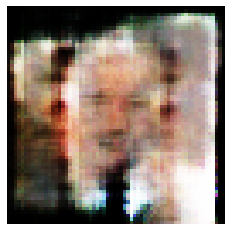

INFO:root:speed: 1162.6269820301707 samples/s
INFO:root:discriminator loss = 0.905568, generator loss = 0.721421, binary training acc = 0.695312 at iter 0 epoch 7
INFO:root:speed: 650.4939999612276 samples/s
INFO:root:discriminator loss = 0.353166, generator loss = 4.754197, binary training acc = 0.920803 at iter 50 epoch 7
INFO:root:speed: 721.9403106300007 samples/s
INFO:root:discriminator loss = 0.203937, generator loss = 4.631623, binary training acc = 0.914217 at iter 100 epoch 7
INFO:root:speed: 704.1243963665265 samples/s
INFO:root:discriminator loss = 0.194449, generator loss = 5.550494, binary training acc = 0.894816 at iter 150 epoch 7
INFO:root:speed: 746.5706673193198 samples/s
INFO:root:discriminator loss = 0.471365, generator loss = 2.682725, binary training acc = 0.901197 at iter 200 epoch 7


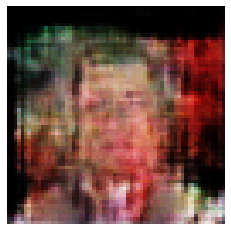

INFO:root:speed: 1212.133533823722 samples/s
INFO:root:discriminator loss = 0.361708, generator loss = 3.103442, binary training acc = 0.976562 at iter 0 epoch 8
INFO:root:speed: 664.6268058798333 samples/s
INFO:root:discriminator loss = 0.306483, generator loss = 4.158381, binary training acc = 0.899050 at iter 50 epoch 8
INFO:root:speed: 707.6941182673802 samples/s
INFO:root:discriminator loss = 0.736581, generator loss = 7.794233, binary training acc = 0.904780 at iter 100 epoch 8
INFO:root:speed: 699.4277019122287 samples/s
INFO:root:discriminator loss = 0.917634, generator loss = 7.444193, binary training acc = 0.891660 at iter 150 epoch 8
INFO:root:speed: 630.7698323182194 samples/s
INFO:root:discriminator loss = 0.216527, generator loss = 4.587560, binary training acc = 0.896300 at iter 200 epoch 8


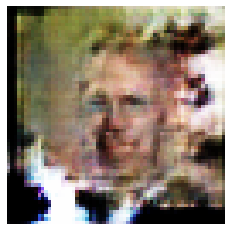

INFO:root:speed: 1114.8809303291455 samples/s
INFO:root:discriminator loss = 0.510045, generator loss = 2.381197, binary training acc = 0.828125 at iter 0 epoch 9
INFO:root:speed: 666.2847271174829 samples/s
INFO:root:discriminator loss = 0.996574, generator loss = 9.456444, binary training acc = 0.898744 at iter 50 epoch 9
INFO:root:speed: 652.1803025775212 samples/s
INFO:root:discriminator loss = 0.165527, generator loss = 4.842860, binary training acc = 0.901377 at iter 100 epoch 9
INFO:root:speed: 689.4468869831437 samples/s
INFO:root:discriminator loss = 0.790813, generator loss = 3.423957, binary training acc = 0.887314 at iter 150 epoch 9
INFO:root:speed: 700.6855997327096 samples/s
INFO:root:discriminator loss = 0.399586, generator loss = 3.928056, binary training acc = 0.880675 at iter 200 epoch 9


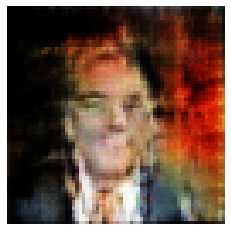

INFO:root:speed: 1227.4758035383582 samples/s
INFO:root:discriminator loss = 0.409202, generator loss = 4.691432, binary training acc = 0.953125 at iter 0 epoch 10
INFO:root:speed: 695.7350542985253 samples/s
INFO:root:discriminator loss = 1.108361, generator loss = 8.614035, binary training acc = 0.910233 at iter 50 epoch 10
INFO:root:speed: 701.1394780282926 samples/s
INFO:root:discriminator loss = 0.161881, generator loss = 5.392240, binary training acc = 0.905554 at iter 100 epoch 10
INFO:root:speed: 719.5715737074754 samples/s
INFO:root:discriminator loss = 0.548389, generator loss = 6.341579, binary training acc = 0.893160 at iter 150 epoch 10
INFO:root:speed: 665.5991113293115 samples/s
INFO:root:discriminator loss = 0.385192, generator loss = 2.653227, binary training acc = 0.895989 at iter 200 epoch 10


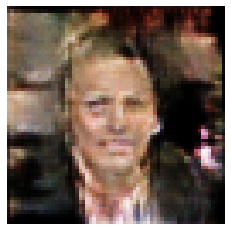

INFO:root:speed: 1328.40832768356 samples/s
INFO:root:discriminator loss = 1.235137, generator loss = 1.391242, binary training acc = 0.570312 at iter 0 epoch 11
INFO:root:speed: 712.8945591871313 samples/s
INFO:root:discriminator loss = 0.487770, generator loss = 5.509722, binary training acc = 0.895987 at iter 50 epoch 11
INFO:root:speed: 700.3656761784497 samples/s
INFO:root:discriminator loss = 1.715285, generator loss = 9.987188, binary training acc = 0.900990 at iter 100 epoch 11
INFO:root:speed: 706.5020555336229 samples/s
INFO:root:discriminator loss = 0.445220, generator loss = 5.408054, binary training acc = 0.890263 at iter 150 epoch 11
INFO:root:speed: 749.3320157551091 samples/s
INFO:root:discriminator loss = 0.586718, generator loss = 5.334170, binary training acc = 0.886194 at iter 200 epoch 11


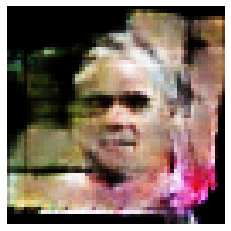

INFO:root:speed: 1318.9375994968652 samples/s
INFO:root:discriminator loss = 0.491649, generator loss = 2.242500, binary training acc = 0.859375 at iter 0 epoch 12
INFO:root:speed: 790.5204730716675 samples/s
INFO:root:discriminator loss = 0.429923, generator loss = 5.901413, binary training acc = 0.869792 at iter 50 epoch 12
INFO:root:speed: 705.6514479190763 samples/s
INFO:root:discriminator loss = 0.305487, generator loss = 3.982971, binary training acc = 0.875000 at iter 100 epoch 12
INFO:root:speed: 736.9235474174021 samples/s
INFO:root:discriminator loss = 0.955532, generator loss = 1.898092, binary training acc = 0.877794 at iter 150 epoch 12
INFO:root:speed: 655.4256065670636 samples/s
INFO:root:discriminator loss = 0.292892, generator loss = 3.343777, binary training acc = 0.873134 at iter 200 epoch 12


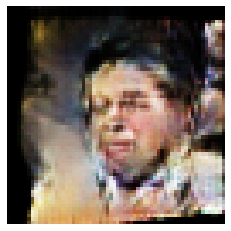

INFO:root:speed: 1291.7785402520656 samples/s
INFO:root:discriminator loss = 0.436233, generator loss = 3.212633, binary training acc = 0.945312 at iter 0 epoch 13
INFO:root:speed: 669.1631231132417 samples/s
INFO:root:discriminator loss = 0.340961, generator loss = 4.128634, binary training acc = 0.869792 at iter 50 epoch 13
INFO:root:speed: 707.2279903045631 samples/s
INFO:root:discriminator loss = 0.319563, generator loss = 4.898379, binary training acc = 0.888923 at iter 100 epoch 13
INFO:root:speed: 698.0835301093277 samples/s
INFO:root:discriminator loss = 0.366479, generator loss = 4.777603, binary training acc = 0.893678 at iter 150 epoch 13
INFO:root:speed: 688.7781857556699 samples/s
INFO:root:discriminator loss = 0.550192, generator loss = 5.588000, binary training acc = 0.889537 at iter 200 epoch 13


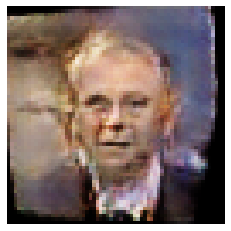

INFO:root:speed: 1105.2776046148715 samples/s
INFO:root:discriminator loss = 0.639156, generator loss = 5.840727, binary training acc = 0.890625 at iter 0 epoch 14
INFO:root:speed: 727.3786557194923 samples/s
INFO:root:discriminator loss = 0.418065, generator loss = 3.800132, binary training acc = 0.835325 at iter 50 epoch 14
INFO:root:speed: 669.9363494788963 samples/s
INFO:root:discriminator loss = 0.419249, generator loss = 4.781943, binary training acc = 0.852104 at iter 100 epoch 14
INFO:root:speed: 683.4905765107883 samples/s
INFO:root:discriminator loss = 1.718887, generator loss = 2.541111, binary training acc = 0.857875 at iter 150 epoch 14
INFO:root:speed: 773.792135689763 samples/s
INFO:root:discriminator loss = 0.318418, generator loss = 4.469774, binary training acc = 0.860230 at iter 200 epoch 14


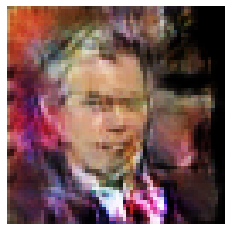

In [36]:
from datetime import datetime
import time
import logging

real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    for batch in train_data:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = batch.data[0].as_in_context(ctx)
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

        with autograd.record():
            # train with real image
            output = netD(data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])

            # train with fake image
            fake = netG(latent_z)
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD_GAN.step(batch.data[0].shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = netG(latent_z)
            output = netD(fake).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG_GAN.step(batch.data[0].shape[0])

        # Print log infomation every ten batches
        if iter % 50 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                       nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    # logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    # logging.info('time: %f' % (time.time() - tic))

    # Visualize one generated image for each epoch
    fake_img = fake[0]
    visualize(fake_img)
    plt.show()

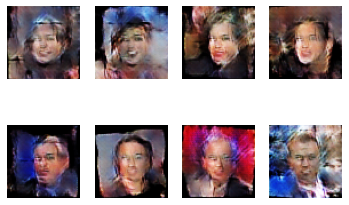

In [37]:
num_image = 8
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    img = netG(latent_z)
    plt.subplot(2,4,i+1)
    visualize(img[0])
plt.show()

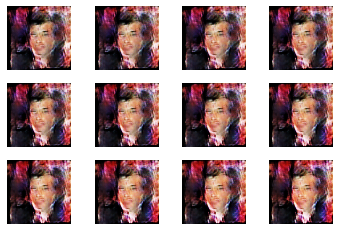

In [38]:
num_image = 12
latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
step = 0.05
for i in range(num_image):
    img = netG(latent_z)
    plt.subplot(3,4,i+1)
    visualize(img[0])
    latent_z += 0.08
plt.show()

### Task 2 (33 points):

Convert the DCGAN to a WGAN.

You can refer to [the WGAN paper](https://arxiv.org/abs/1701.07875) and/or the below notes.

The paper introduces a new loss function for both the discriminator and the generator. Using this loss function instead of binary cross entropy results in a more stable convergence of the GAN.

#### Loss

Let’s compare the binary cross-entropy loss function (the function that that we are currently using to train the discriminator and generator of the DCGAN) to the Wasserstein loss function.

First, the Wasserstein loss requires that we use yi=1 and yi=-1 as labels, rather than 1 and 0. We also remove the sigmoid activation from the final layer of the discriminator, so that predictions pi are no longer constrained to fall in the range [0,1], but instead can now be any number in the range [–∞, ∞]. For this reason, the discriminator in a WGAN is usually referred to as a critic. The Wasserstein loss function is then defined as follows:

$$-\frac{1}{n} \sum_{i=1}^{n}\left(y_{i} p_{i}\right)$$

To train the WGAN critic D, we calculate the loss when comparing predictions for a real images pi=D(xi) to the response yi=1 and predictions for generated images pi=D(G(zi)) to the response yi=-1. Therefore for the WGAN critic, minimizing the loss function can be written as follows:

$$\min _{D}-\left(\mathbb{E}_{x \sim p_{X}}[D(x)]-\mathbb{E}_{z \sim p_{Z}}[D(G(z))]\right)$$

In other words, the WGAN critic tries to maximise the difference between its predictions for real images and generated images, with real images scoring higher. To train the WGAN generator, we calculate the loss when comparing predictions for generated images pi=D(G(zi)) to the response yi=1. Therefore for the WGAN generator, minimizing the loss function can be written as follows:

$$\min _{G}-\left(\mathbb{E}_{z \sim p_{Z}}[D(G(z))]\right)$$

#### Constraints

For the Wasserstein loss function to work, we also need to place an additional constraint on the critic. Specifically, it is required that the critic is a 1-Lipschitz continuous function. Let’s pick this apart to understand what it means in more detail. The critic is a function D that converts an image into a prediction. We say that this function is 1-Lipschitz if it satisfies the following inequality for any two input images, \( x_1 \) and \( x_2 \):

$$ \vert\frac{D(x_1)-D(x_2)\vert}{\vert x_1-x_2\vert}\leq1 $$

Essentially, we require a limit on the rate at which the predictions of the critic can change between two images (i.e., the absolute value of the gradient must be at most 1 everywhere).

It is possible to enforce the Lipschitz constraint by clipping the weights of the critic to lie within a small range, [–0.01, 0.01], after each training batch.

#### Training

When using the Wasserstein loss function, we should train the critic to convergence to ensure that the gradients for the generator update are accurate. This is in contrast to a standard GAN, where it is important not to let the discriminator get too strong, to avoid vanishing gradients.

Therefore, using the Wasserstein loss removes one of the key difficulties of training GANs—how to balance the training of the discriminator and generator. With WGANs, we can simply train the critic several times between generator updates, to ensure it is close to convergence. A typical ratio used is five critic updates to one generator update.

In [39]:
netG , netD = build_network()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG_WGAN = gluon.Trainer(netG.collect_params(), 'rmsprop' ,{'learning_rate': 0.0005})
trainerD_WGAN = gluon.Trainer(netD.collect_params(), 'rmsprop', {'learning_rate': 0.0005,'clip_weights': 0.01})

INFO:root:speed: 112.89174379986989 samples/s
INFO:root:discriminator loss = -0.154511, generator loss = 0.099847, binary training acc = 0.500000 at iter 0 epoch 0
INFO:root:speed: 225.47843244310235 samples/s
INFO:root:discriminator loss = -0.936258, generator loss = 0.625948, binary training acc = 0.321170 at iter 50 epoch 0
INFO:root:speed: 219.26558671118923 samples/s
INFO:root:discriminator loss = -1.315539, generator loss = 0.629065, binary training acc = 0.240347 at iter 100 epoch 0
INFO:root:speed: 218.81178721326523 samples/s
INFO:root:discriminator loss = -1.244716, generator loss = 0.580198, binary training acc = 0.207916 at iter 150 epoch 0
INFO:root:speed: 216.3510937021455 samples/s
INFO:root:discriminator loss = -1.200141, generator loss = 0.550770, binary training acc = 0.197660 at iter 200 epoch 0


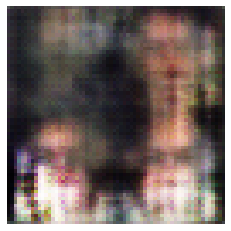

INFO:root:speed: 247.7009083627693 samples/s
INFO:root:discriminator loss = -1.125156, generator loss = 0.543241, binary training acc = 0.278125 at iter 0 epoch 1
INFO:root:speed: 218.48782766810515 samples/s
INFO:root:discriminator loss = -1.275657, generator loss = 0.629168, binary training acc = 0.176961 at iter 50 epoch 1
INFO:root:speed: 215.2529176389457 samples/s
INFO:root:discriminator loss = -1.047892, generator loss = 0.621282, binary training acc = 0.191027 at iter 100 epoch 1
INFO:root:speed: 227.85765361383397 samples/s
INFO:root:discriminator loss = -1.157936, generator loss = 0.628425, binary training acc = 0.196471 at iter 150 epoch 1
INFO:root:speed: 220.85364290445062 samples/s
INFO:root:discriminator loss = -1.163551, generator loss = 0.577944, binary training acc = 0.203382 at iter 200 epoch 1


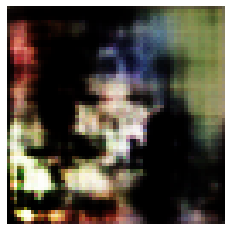

INFO:root:speed: 254.81677353824833 samples/s
INFO:root:discriminator loss = -1.271006, generator loss = 0.606862, binary training acc = 0.087500 at iter 0 epoch 2
INFO:root:speed: 223.13020637649163 samples/s
INFO:root:discriminator loss = -0.757715, generator loss = 0.319059, binary training acc = 0.229105 at iter 50 epoch 2
INFO:root:speed: 217.2389660985264 samples/s
INFO:root:discriminator loss = -0.988907, generator loss = 0.608791, binary training acc = 0.240331 at iter 100 epoch 2
INFO:root:speed: 215.93601287078934 samples/s
INFO:root:discriminator loss = -1.203169, generator loss = 0.546332, binary training acc = 0.244526 at iter 150 epoch 2
INFO:root:speed: 217.30720054789154 samples/s
INFO:root:discriminator loss = -0.716739, generator loss = 0.617544, binary training acc = 0.252519 at iter 200 epoch 2


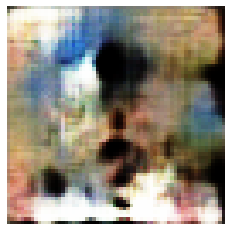

INFO:root:speed: 257.5938462010886 samples/s
INFO:root:discriminator loss = -0.960338, generator loss = 0.599534, binary training acc = 0.315625 at iter 0 epoch 3
INFO:root:speed: 213.61160926016112 samples/s
INFO:root:discriminator loss = -1.181428, generator loss = 0.556323, binary training acc = 0.284069 at iter 50 epoch 3
INFO:root:speed: 224.23718554345692 samples/s
INFO:root:discriminator loss = -1.170547, generator loss = 0.547235, binary training acc = 0.290316 at iter 100 epoch 3
INFO:root:speed: 224.30670140565906 samples/s
INFO:root:discriminator loss = -0.744545, generator loss = 0.355588, binary training acc = 0.291567 at iter 150 epoch 3
INFO:root:speed: 218.40178994215233 samples/s
INFO:root:discriminator loss = -0.868829, generator loss = 0.576224, binary training acc = 0.297435 at iter 200 epoch 3


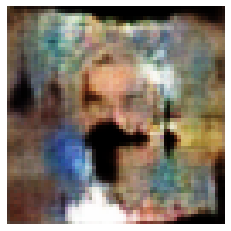

INFO:root:speed: 262.52856332518337 samples/s
INFO:root:discriminator loss = -0.902559, generator loss = 0.406433, binary training acc = 0.318750 at iter 0 epoch 4
INFO:root:speed: 219.57227996184986 samples/s
INFO:root:discriminator loss = -1.102442, generator loss = 0.479298, binary training acc = 0.312224 at iter 50 epoch 4
INFO:root:speed: 223.69584050693248 samples/s
INFO:root:discriminator loss = -1.068433, generator loss = 0.608911, binary training acc = 0.318998 at iter 100 epoch 4
INFO:root:speed: 221.99829636331458 samples/s
INFO:root:discriminator loss = -0.854834, generator loss = 0.320387, binary training acc = 0.318905 at iter 150 epoch 4
INFO:root:speed: 221.00037706707678 samples/s
INFO:root:discriminator loss = -0.741496, generator loss = 0.333398, binary training acc = 0.323204 at iter 200 epoch 4


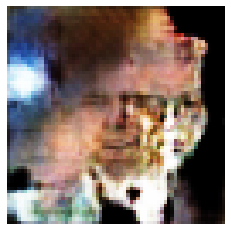

INFO:root:speed: 263.2458277517029 samples/s
INFO:root:discriminator loss = -0.849690, generator loss = 0.381698, binary training acc = 0.384375 at iter 0 epoch 5
INFO:root:speed: 220.2388307551947 samples/s
INFO:root:discriminator loss = -1.093364, generator loss = 0.549699, binary training acc = 0.336244 at iter 50 epoch 5
INFO:root:speed: 216.4664154461127 samples/s
INFO:root:discriminator loss = -0.862162, generator loss = 0.318702, binary training acc = 0.337283 at iter 100 epoch 5
INFO:root:speed: 213.3917056918932 samples/s
INFO:root:discriminator loss = -0.842968, generator loss = 0.582036, binary training acc = 0.336320 at iter 150 epoch 5
INFO:root:speed: 227.84991732618977 samples/s
INFO:root:discriminator loss = -0.999664, generator loss = 0.437034, binary training acc = 0.339187 at iter 200 epoch 5


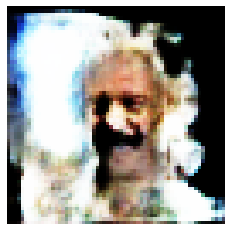

INFO:root:speed: 272.0091117096413 samples/s
INFO:root:discriminator loss = -0.925534, generator loss = 0.605367, binary training acc = 0.365625 at iter 0 epoch 6
INFO:root:speed: 221.13582899330584 samples/s
INFO:root:discriminator loss = -0.933256, generator loss = 0.450634, binary training acc = 0.346262 at iter 50 epoch 6
INFO:root:speed: 221.9529578105298 samples/s
INFO:root:discriminator loss = -0.893678, generator loss = 0.367332, binary training acc = 0.347896 at iter 100 epoch 6
INFO:root:speed: 218.60312486257672 samples/s
INFO:root:discriminator loss = -0.918431, generator loss = 0.571742, binary training acc = 0.347806 at iter 150 epoch 6
INFO:root:speed: 214.16702981427213 samples/s
INFO:root:discriminator loss = -1.069623, generator loss = 0.553893, binary training acc = 0.350731 at iter 200 epoch 6


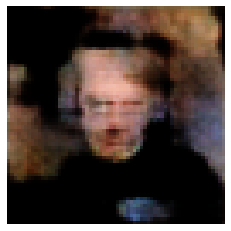

INFO:root:speed: 257.7855611137093 samples/s
INFO:root:discriminator loss = -0.803862, generator loss = 0.236007, binary training acc = 0.373437 at iter 0 epoch 7
INFO:root:speed: 227.08757705703258 samples/s
INFO:root:discriminator loss = -0.902505, generator loss = 0.391486, binary training acc = 0.351379 at iter 50 epoch 7
INFO:root:speed: 218.89493533911593 samples/s
INFO:root:discriminator loss = -0.951844, generator loss = 0.573838, binary training acc = 0.354626 at iter 100 epoch 7
INFO:root:speed: 221.04259695686616 samples/s
INFO:root:discriminator loss = -1.050560, generator loss = 0.591721, binary training acc = 0.352887 at iter 150 epoch 7
INFO:root:speed: 224.49522927017745 samples/s
INFO:root:discriminator loss = -1.028664, generator loss = 0.475295, binary training acc = 0.353739 at iter 200 epoch 7


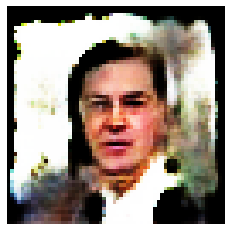

INFO:root:speed: 264.8844155254656 samples/s
INFO:root:discriminator loss = -0.619293, generator loss = 0.259084, binary training acc = 0.409375 at iter 0 epoch 8
INFO:root:speed: 217.98748442862177 samples/s
INFO:root:discriminator loss = -0.899344, generator loss = 0.355883, binary training acc = 0.357537 at iter 50 epoch 8
INFO:root:speed: 220.344407652263 samples/s
INFO:root:discriminator loss = -0.870627, generator loss = 0.389828, binary training acc = 0.358060 at iter 100 epoch 8
INFO:root:speed: 220.27045705006225 samples/s
INFO:root:discriminator loss = -1.005358, generator loss = 0.394602, binary training acc = 0.357864 at iter 150 epoch 8
INFO:root:speed: 218.76720587887732 samples/s
INFO:root:discriminator loss = -0.920081, generator loss = 0.564023, binary training acc = 0.360805 at iter 200 epoch 8


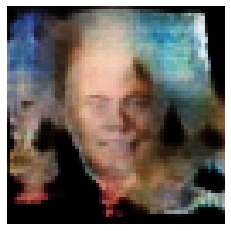

INFO:root:speed: 273.0694444727018 samples/s
INFO:root:discriminator loss = -0.777251, generator loss = 0.596734, binary training acc = 0.362500 at iter 0 epoch 9
INFO:root:speed: 224.03057897244972 samples/s
INFO:root:discriminator loss = -0.772326, generator loss = 0.209819, binary training acc = 0.362194 at iter 50 epoch 9
INFO:root:speed: 220.104475139843 samples/s
INFO:root:discriminator loss = -0.869314, generator loss = 0.330748, binary training acc = 0.362175 at iter 100 epoch 9
INFO:root:speed: 211.8808540733134 samples/s
INFO:root:discriminator loss = -1.027163, generator loss = 0.564551, binary training acc = 0.361186 at iter 150 epoch 9
INFO:root:speed: 218.59013005372015 samples/s
INFO:root:discriminator loss = -0.976790, generator loss = 0.500487, binary training acc = 0.362111 at iter 200 epoch 9


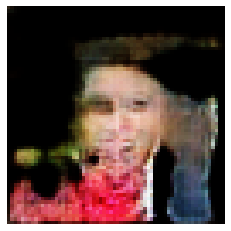

INFO:root:speed: 258.0003729169991 samples/s
INFO:root:discriminator loss = -0.886911, generator loss = 0.413001, binary training acc = 0.367188 at iter 0 epoch 10
INFO:root:speed: 222.92692965358708 samples/s
INFO:root:discriminator loss = -0.966149, generator loss = 0.439682, binary training acc = 0.364338 at iter 50 epoch 10
INFO:root:speed: 215.6920607039921 samples/s
INFO:root:discriminator loss = -1.055664, generator loss = 0.495594, binary training acc = 0.364944 at iter 100 epoch 10
INFO:root:speed: 218.2370144176752 samples/s
INFO:root:discriminator loss = -0.945911, generator loss = 0.586295, binary training acc = 0.364570 at iter 150 epoch 10
INFO:root:speed: 225.35236542557345 samples/s
INFO:root:discriminator loss = -0.879814, generator loss = 0.352154, binary training acc = 0.366216 at iter 200 epoch 10


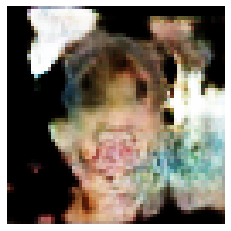

INFO:root:speed: 267.6469680321772 samples/s
INFO:root:discriminator loss = -0.926393, generator loss = 0.409955, binary training acc = 0.339062 at iter 0 epoch 11
INFO:root:speed: 222.81054143114454 samples/s
INFO:root:discriminator loss = -0.982806, generator loss = 0.592308, binary training acc = 0.370312 at iter 50 epoch 11
INFO:root:speed: 215.76643715708198 samples/s
INFO:root:discriminator loss = -0.858612, generator loss = 0.582911, binary training acc = 0.370127 at iter 100 epoch 11
INFO:root:speed: 226.60621480849915 samples/s
INFO:root:discriminator loss = -1.009370, generator loss = 0.593648, binary training acc = 0.367674 at iter 150 epoch 11
INFO:root:speed: 214.78152706777925 samples/s
INFO:root:discriminator loss = -0.927999, generator loss = 0.481842, binary training acc = 0.368820 at iter 200 epoch 11


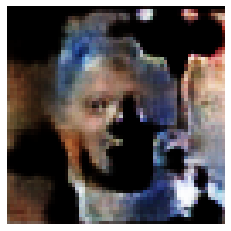

INFO:root:speed: 261.80855778533754 samples/s
INFO:root:discriminator loss = -0.866447, generator loss = 0.595781, binary training acc = 0.398438 at iter 0 epoch 12
INFO:root:speed: 217.57210257607332 samples/s
INFO:root:discriminator loss = -0.907718, generator loss = 0.377482, binary training acc = 0.366820 at iter 50 epoch 12
INFO:root:speed: 223.94647351748912 samples/s
INFO:root:discriminator loss = -1.012655, generator loss = 0.541349, binary training acc = 0.367590 at iter 100 epoch 12
INFO:root:speed: 219.8881176164131 samples/s
INFO:root:discriminator loss = -1.033716, generator loss = 0.583663, binary training acc = 0.367415 at iter 150 epoch 12
INFO:root:speed: 217.62572508680773 samples/s
INFO:root:discriminator loss = -1.039257, generator loss = 0.519338, binary training acc = 0.369535 at iter 200 epoch 12


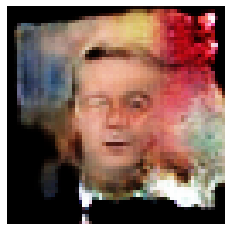

INFO:root:speed: 274.36531352113224 samples/s
INFO:root:discriminator loss = -0.891032, generator loss = 0.266271, binary training acc = 0.381250 at iter 0 epoch 13
INFO:root:speed: 207.07627176173636 samples/s
INFO:root:discriminator loss = -0.848628, generator loss = 0.395512, binary training acc = 0.367586 at iter 50 epoch 13
INFO:root:speed: 226.75667255728143 samples/s
INFO:root:discriminator loss = -0.952016, generator loss = 0.583291, binary training acc = 0.372215 at iter 100 epoch 13
INFO:root:speed: 212.53864303608245 samples/s
INFO:root:discriminator loss = -1.026501, generator loss = 0.546968, binary training acc = 0.369743 at iter 150 epoch 13
INFO:root:speed: 227.68738342529252 samples/s
INFO:root:discriminator loss = -0.974449, generator loss = 0.444952, binary training acc = 0.372248 at iter 200 epoch 13


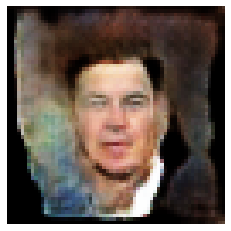

INFO:root:speed: 270.8462585473298 samples/s
INFO:root:discriminator loss = -1.018505, generator loss = 0.562850, binary training acc = 0.379688 at iter 0 epoch 14
INFO:root:speed: 214.4125090458306 samples/s
INFO:root:discriminator loss = -0.989173, generator loss = 0.396812, binary training acc = 0.374112 at iter 50 epoch 14
INFO:root:speed: 223.8389106388656 samples/s
INFO:root:discriminator loss = -0.825743, generator loss = 0.383966, binary training acc = 0.373577 at iter 100 epoch 14
INFO:root:speed: 221.01875529522772 samples/s
INFO:root:discriminator loss = -0.933703, generator loss = 0.374167, binary training acc = 0.372237 at iter 150 epoch 14
INFO:root:speed: 225.9521573308171 samples/s
INFO:root:discriminator loss = -0.826653, generator loss = 0.450617, binary training acc = 0.373803 at iter 200 epoch 14


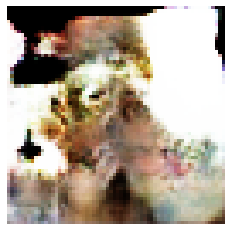

In [40]:
from datetime import datetime
import time
import logging

real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    for batch in train_data:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = batch.data[0].as_in_context(ctx)
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)
        for i in range(5):
            with autograd.record():
                # train with real image
                output = netD(data).reshape((-1, 1))
                errD_real = output
                metric.update([real_label,], [output,])

                # train with fake image
                fake = netG(latent_z)
                output = netD(fake.detach()).reshape((-1, 1))
                errD_fake = output
                errD =  errD_real - errD_fake
                errD.backward()
                metric.update([fake_label,], [output,])
       
            trainerD_WGAN.step(batch.data[0].shape[0])  

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = netG(latent_z)
            output = netD(fake).reshape((-1, 1))
            errG = output
            errG.backward()

        trainerG_WGAN.step(batch.data[0].shape[0])

        # Print log infomation every fifty batches
        if iter % 50 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                       nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    # logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    # logging.info('time: %f' % (time.time() - tic))

    # Visualize one generated image for each epoch
    fake_img = fake[0]
    visualize(fake_img)
    plt.show()

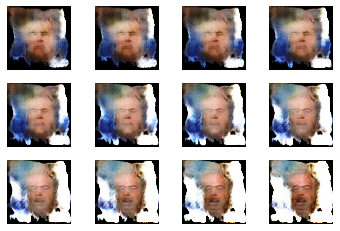

In [41]:
num_image = 12
latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
step = 0.05
for i in range(num_image):
    img = netG(latent_z)
    plt.subplot(3,4,i+1)
    visualize(img[0])
    latent_z += 0.08
plt.show()

### Task 3 (33 points):

Compare their results of the DCGAN and the WGAN after training them on different datasets (at least three). You are free to select which datasets to use (it would be easier if you use relatively small datasets). For example, you can use MNIST and Fashion-MNIST datasets (available from Gluon) or anime characters and pokemons datasets (several versions can be found on GitHub).

In [42]:
# Your code here...